In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster, cophenet
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from scipy import stats
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import AgglomerativeClustering

from scipy.stats import spearmanr
from scipy.stats import pearsonr
import statistics

from sklearn.feature_selection import VarianceThreshold
# for data imbalance, SMOTE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight

# to calculate the performance of the models
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [297]:
def pearson_COR(spec1,spec2):
    pcorr, _ = pearsonr(spec1,spec2)
    return pcorr

def spearman_COR(spec1,spec2):
    scorr, _ = spearmanr(spec1,spec2)
    return scorr

def pairwise_COR(df):
    pearsonCOR=[]
    spearmanCOR =[]
    for i in range(df.shape[0]):
        for j in range(i+1,df.shape[0]):
            result = spec_COR(df.iloc[i,0:],df.iloc[j,0:])
            pearsonCOR.append(result[0])
            spearmanCOR.append(result[1])
    return pearsonCOR, spearmanCOR

def Pearson_matrix(df,i0):
    COR_pearson = pd.DataFrame()
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
            COR_pearson.loc[i,j] =pearson_COR(df.iloc[i,i0:],df.iloc[j,i0:])
    return COR_pearson

def Spearman_matrix(df,i0):
    COR__spearman= pd.DataFrame()
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
            COR__spearman.loc[i,j] =spearman_COR(df.iloc[i,i0:],df.iloc[j,i0:])
    return COR__spearman

def min_max_scaler(x):
    norm_x = (x-min(x))/(max(x)-min(x))
    return norm_x

Feature dimension of the DFT IR dataset

In [36]:
count = 400
full_feature = []
for i in range(1801):
    #print(count)
    full_feature.append(int(count))
    count += int(2)
print("Number of features:",len(full_feature))
print("First feature:",full_feature[0])
print("Last feature:",full_feature[-1])
col_index = np.arange(1,1802)
print(len(col_index))

Number of features: 1801
First feature: 400
Last feature: 4000
1801


In [7]:
path = "/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/ML results/"
df = pd.read_csv(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset.csv")
df_unique = pd.read_csv(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset - Unique compounds.csv")
print("Number of samples:",df.shape[0],"Number of features:",df.shape[1]-2)
print("Number of unique drug compounds:", df_unique.shape[0])
df.head(2)

Number of samples: 930 Number of features: 1801
Number of unique drug compounds: 127


,Drug,Class,400,402,404,406,408,410,412,414,...,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,Heroin_0,1.0,0.008913,0.008557,0.008188,0.007875,0.007665,0.007587,0.007654,0.007875,...,0.000005,0.000004,0.000004,0.000003,0.000003,0.000002,0.000002,1.023970e-06,5.107461e-07,0.0
1,Heroin_1,1.0,0.008733,0.008339,0.007896,0.007482,0.007154,0.006941,0.006856,0.006906,...,0.000004,0.000004,0.000003,0.000003,0.000002,0.000002,0.000001,9.826807e-07,4.901463e-07,0.0


#### Split original data as 90% training and 10% test

In [8]:
X = df.drop(['Drug','Class'],axis=1)
Y = df['Class'].astype('int64')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
print('Size of training set',Y_train.shape[0])
print('Size of test set',Y_test.shape[0])

Size of training set 837
Size of test set 93


## I. Prepare datasets

### 0. Remove Low Variance (Quasi constant) Features
Constant features are those that show the same value, just one value, for all the rows of the dataset. 
These features provide no information that allows a machine learning model to discriminate or predict a target.

The Sklearn VarianceThreshold removes all features which variance doesn't meet a certain threshold. 
By default, it removes all zero-variance features.

#### Select the features by examining only the training set to avoid overfit

#### Output: df_variance

In [10]:
def check_low_variance(X_Train):
    # Calculate feature variance
    i = 0
    variance = []
    for column in X_Train:
        i = 1+1
        #print(statistics.variance(df[column]))
        variance.append(statistics.variance(X_Train[column]))
    # Sort in ascending order
    variance.sort()
    plt.hist(variance, bins=100)
    plt.title('Variance distribution')
    plt.show()
    
    #Check number of features to remove for each variance threshold
    features_to_remove = []
    for thres in variance[0:1800]:
        sel = VarianceThreshold(threshold=thres)
        sel.fit_transform(X_Train)
        false_count = (~sel.get_support()).sum()
        features_to_remove.append(false_count)
        print("Variance threshold=",thres, "Number of Features to remove:", false_count)
        true_count = sel.get_support().sum()
        print("Number of Features to retain:", true_count)
        
    fig = plt.figure(figsize=(6,3), dpi=300)
    plt.rc('font', family='serif', size = 10)
    plt.xlabel('Feature variance')
    plt.ylabel('Number of features to remove by variance threshold')
    plt.scatter(variance[0:1800],features_to_remove)
    plt.show()

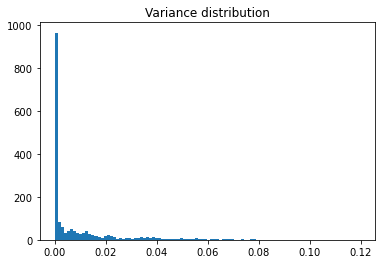

Variance threshold= 9.603693761858206e-10 Number of Features to remove: 1
Number of Features to retain: 1800
Variance threshold= 1.0302773931952203e-09 Number of Features to remove: 2
Number of Features to retain: 1799
Variance threshold= 1.1214278141320526e-09 Number of Features to remove: 3
Number of Features to retain: 1798
Variance threshold= 1.2350308255406457e-09 Number of Features to remove: 4
Number of Features to retain: 1797
Variance threshold= 1.3723653045574914e-09 Number of Features to remove: 5
Number of Features to retain: 1796
Variance threshold= 1.5347831001084822e-09 Number of Features to remove: 6
Number of Features to retain: 1795
Variance threshold= 1.7237136115180995e-09 Number of Features to remove: 7
Number of Features to retain: 1794
Variance threshold= 1.9406686875273324e-09 Number of Features to remove: 8
Number of Features to retain: 1793
Variance threshold= 2.1872478706855277e-09 Number of Features to remove: 9
Number of Features to retain: 1792
Variance th

Variance threshold= 8.526630187762881e-08 Number of Features to remove: 82
Number of Features to retain: 1719
Variance threshold= 8.53193035865948e-08 Number of Features to remove: 82
Number of Features to retain: 1719
Variance threshold= 8.555998452913796e-08 Number of Features to remove: 84
Number of Features to retain: 1717
Variance threshold= 8.563704814993279e-08 Number of Features to remove: 84
Number of Features to retain: 1717
Variance threshold= 8.587180006548718e-08 Number of Features to remove: 85
Number of Features to retain: 1716
Variance threshold= 8.59768628321619e-08 Number of Features to remove: 86
Number of Features to retain: 1715
Variance threshold= 8.62018032294362e-08 Number of Features to remove: 87
Number of Features to retain: 1714
Variance threshold= 8.63390614720901e-08 Number of Features to remove: 88
Number of Features to retain: 1713
Variance threshold= 8.655005878901804e-08 Number of Features to remove: 89
Number of Features to retain: 1712
Variance thres

Variance threshold= 1.1155160814714411e-07 Number of Features to remove: 159
Number of Features to retain: 1642
Variance threshold= 1.1247194485451458e-07 Number of Features to remove: 160
Number of Features to retain: 1641
Variance threshold= 1.1269597798869202e-07 Number of Features to remove: 161
Number of Features to retain: 1640
Variance threshold= 1.138604367940067e-07 Number of Features to remove: 163
Number of Features to retain: 1638
Variance threshold= 1.138695266857651e-07 Number of Features to remove: 163
Number of Features to retain: 1638
Variance threshold= 1.1507285324940927e-07 Number of Features to remove: 164
Number of Features to retain: 1637
Variance threshold= 1.1529311413767606e-07 Number of Features to remove: 165
Number of Features to retain: 1636
Variance threshold= 1.1601467991071885e-07 Number of Features to remove: 166
Number of Features to retain: 1635
Variance threshold= 1.1630657878775622e-07 Number of Features to remove: 167
Number of Features to retain:

Variance threshold= 1.826953119212832e-07 Number of Features to remove: 236
Number of Features to retain: 1565
Variance threshold= 1.8562849821794312e-07 Number of Features to remove: 237
Number of Features to retain: 1564
Variance threshold= 1.8599572015099083e-07 Number of Features to remove: 238
Number of Features to retain: 1563
Variance threshold= 1.8801459436683725e-07 Number of Features to remove: 239
Number of Features to retain: 1562
Variance threshold= 1.8863835210042256e-07 Number of Features to remove: 240
Number of Features to retain: 1561
Variance threshold= 1.8959671763276745e-07 Number of Features to remove: 241
Number of Features to retain: 1560
Variance threshold= 1.917272234560177e-07 Number of Features to remove: 242
Number of Features to retain: 1559
Variance threshold= 1.9330542054411505e-07 Number of Features to remove: 243
Number of Features to retain: 1558
Variance threshold= 1.948975529557339e-07 Number of Features to remove: 244
Number of Features to retain: 

Variance threshold= 3.5399757464696166e-07 Number of Features to remove: 311
Number of Features to retain: 1490
Variance threshold= 3.5922471622410143e-07 Number of Features to remove: 312
Number of Features to retain: 1489
Variance threshold= 3.6072644487126867e-07 Number of Features to remove: 313
Number of Features to retain: 1488
Variance threshold= 3.6826694041191103e-07 Number of Features to remove: 314
Number of Features to retain: 1487
Variance threshold= 3.68887963043001e-07 Number of Features to remove: 315
Number of Features to retain: 1486
Variance threshold= 3.773143814709095e-07 Number of Features to remove: 317
Number of Features to retain: 1484
Variance threshold= 3.7760885719162875e-07 Number of Features to remove: 317
Number of Features to retain: 1484
Variance threshold= 3.8045310828680106e-07 Number of Features to remove: 318
Number of Features to retain: 1483
Variance threshold= 3.8601633911426386e-07 Number of Features to remove: 319
Number of Features to retain: 

Variance threshold= 8.378191747648118e-07 Number of Features to remove: 391
Number of Features to retain: 1410
Variance threshold= 8.400527173127774e-07 Number of Features to remove: 392
Number of Features to retain: 1409
Variance threshold= 8.447757609395182e-07 Number of Features to remove: 393
Number of Features to retain: 1408
Variance threshold= 8.464062807869016e-07 Number of Features to remove: 394
Number of Features to retain: 1407
Variance threshold= 8.541082047668997e-07 Number of Features to remove: 397
Number of Features to retain: 1404
Variance threshold= 8.54402850499441e-07 Number of Features to remove: 397
Number of Features to retain: 1404
Variance threshold= 8.549571210997745e-07 Number of Features to remove: 397
Number of Features to retain: 1404
Variance threshold= 8.587202825129378e-07 Number of Features to remove: 398
Number of Features to retain: 1403
Variance threshold= 8.639535088330647e-07 Number of Features to remove: 399
Number of Features to retain: 1402
Va

Variance threshold= 1.4462992165287734e-06 Number of Features to remove: 468
Number of Features to retain: 1333
Variance threshold= 1.4665681892200386e-06 Number of Features to remove: 469
Number of Features to retain: 1332
Variance threshold= 1.473793233443959e-06 Number of Features to remove: 470
Number of Features to retain: 1331
Variance threshold= 1.47818516358033e-06 Number of Features to remove: 471
Number of Features to retain: 1330
Variance threshold= 1.5201175293823503e-06 Number of Features to remove: 474
Number of Features to retain: 1327
Variance threshold= 1.5211728132151494e-06 Number of Features to remove: 474
Number of Features to retain: 1327
Variance threshold= 1.5217289148331213e-06 Number of Features to remove: 474
Number of Features to retain: 1327
Variance threshold= 1.5346132869135087e-06 Number of Features to remove: 475
Number of Features to retain: 1326
Variance threshold= 1.5686453216269e-06 Number of Features to remove: 476
Number of Features to retain: 132

Variance threshold= 3.1659419055556057e-06 Number of Features to remove: 542
Number of Features to retain: 1259
Variance threshold= 3.25236037188896e-06 Number of Features to remove: 543
Number of Features to retain: 1258
Variance threshold= 3.3010299563938433e-06 Number of Features to remove: 544
Number of Features to retain: 1257
Variance threshold= 3.3144193846682226e-06 Number of Features to remove: 545
Number of Features to retain: 1256
Variance threshold= 3.392283831532215e-06 Number of Features to remove: 546
Number of Features to retain: 1255
Variance threshold= 3.4038299731619266e-06 Number of Features to remove: 547
Number of Features to retain: 1254
Variance threshold= 3.4358542205316753e-06 Number of Features to remove: 548
Number of Features to retain: 1253
Variance threshold= 3.46535044114457e-06 Number of Features to remove: 549
Number of Features to retain: 1252
Variance threshold= 3.472191360742866e-06 Number of Features to remove: 550
Number of Features to retain: 125

Variance threshold= 9.414607516021122e-06 Number of Features to remove: 616
Number of Features to retain: 1185
Variance threshold= 9.536284851037021e-06 Number of Features to remove: 617
Number of Features to retain: 1184
Variance threshold= 9.738510329468143e-06 Number of Features to remove: 618
Number of Features to retain: 1183
Variance threshold= 9.873215619855543e-06 Number of Features to remove: 620
Number of Features to retain: 1181
Variance threshold= 9.875538196576069e-06 Number of Features to remove: 620
Number of Features to retain: 1181
Variance threshold= 1.0081743326576537e-05 Number of Features to remove: 621
Number of Features to retain: 1180
Variance threshold= 1.0389818082875687e-05 Number of Features to remove: 622
Number of Features to retain: 1179
Variance threshold= 1.0431749053341588e-05 Number of Features to remove: 623
Number of Features to retain: 1178
Variance threshold= 1.0818943669990769e-05 Number of Features to remove: 624
Number of Features to retain: 11

Variance threshold= 4.197030165707754e-05 Number of Features to remove: 693
Number of Features to retain: 1108
Variance threshold= 4.2305229137613915e-05 Number of Features to remove: 694
Number of Features to retain: 1107
Variance threshold= 4.36349597700889e-05 Number of Features to remove: 695
Number of Features to retain: 1106
Variance threshold= 4.3759771079500434e-05 Number of Features to remove: 696
Number of Features to retain: 1105
Variance threshold= 4.5184244753078264e-05 Number of Features to remove: 697
Number of Features to retain: 1104
Variance threshold= 4.548936718824806e-05 Number of Features to remove: 698
Number of Features to retain: 1103
Variance threshold= 4.6925672095541177e-05 Number of Features to remove: 699
Number of Features to retain: 1102
Variance threshold= 4.704291964449972e-05 Number of Features to remove: 700
Number of Features to retain: 1101
Variance threshold= 5.094666030048957e-05 Number of Features to remove: 701
Number of Features to retain: 110

Variance threshold= 0.00019133492732208642 Number of Features to remove: 771
Number of Features to retain: 1030
Variance threshold= 0.0001976822213790878 Number of Features to remove: 772
Number of Features to retain: 1029
Variance threshold= 0.00019901462196385812 Number of Features to remove: 773
Number of Features to retain: 1028
Variance threshold= 0.00020280877798793033 Number of Features to remove: 774
Number of Features to retain: 1027
Variance threshold= 0.00020334680714990952 Number of Features to remove: 776
Number of Features to retain: 1025
Variance threshold= 0.00020344603905360213 Number of Features to remove: 776
Number of Features to retain: 1025
Variance threshold= 0.00021060963596906336 Number of Features to remove: 777
Number of Features to retain: 1024
Variance threshold= 0.00021271948935623752 Number of Features to remove: 778
Number of Features to retain: 1023
Variance threshold= 0.00021476018667206903 Number of Features to remove: 779
Number of Features to retain

Variance threshold= 0.00052872523151152 Number of Features to remove: 848
Number of Features to retain: 953
Variance threshold= 0.0005433725937549287 Number of Features to remove: 849
Number of Features to retain: 952
Variance threshold= 0.0005446852943385408 Number of Features to remove: 850
Number of Features to retain: 951
Variance threshold= 0.0005471340836924645 Number of Features to remove: 852
Number of Features to retain: 949
Variance threshold= 0.0005472674641122047 Number of Features to remove: 852
Number of Features to retain: 949
Variance threshold= 0.0005501040161999805 Number of Features to remove: 854
Number of Features to retain: 947
Variance threshold= 0.0005503827455402046 Number of Features to remove: 854
Number of Features to retain: 947
Variance threshold= 0.0005540070111180081 Number of Features to remove: 855
Number of Features to retain: 946
Variance threshold= 0.0005633022569701278 Number of Features to remove: 856
Number of Features to retain: 945
Variance thr

Variance threshold= 0.0009206501048008433 Number of Features to remove: 926
Number of Features to retain: 875
Variance threshold= 0.0009216901003476387 Number of Features to remove: 926
Number of Features to retain: 875
Variance threshold= 0.000928415338311539 Number of Features to remove: 927
Number of Features to retain: 874
Variance threshold= 0.0009300695507623077 Number of Features to remove: 928
Number of Features to retain: 873
Variance threshold= 0.0009347634686061154 Number of Features to remove: 929
Number of Features to retain: 872
Variance threshold= 0.0009461511166552307 Number of Features to remove: 930
Number of Features to retain: 871
Variance threshold= 0.00095322967656722 Number of Features to remove: 931
Number of Features to retain: 870
Variance threshold= 0.0009547879654682401 Number of Features to remove: 932
Number of Features to retain: 869
Variance threshold= 0.0009582633841166687 Number of Features to remove: 934
Number of Features to retain: 867
Variance thre

Variance threshold= 0.001819415787198106 Number of Features to remove: 1001
Number of Features to retain: 800
Variance threshold= 0.001843617303216384 Number of Features to remove: 1002
Number of Features to retain: 799
Variance threshold= 0.001899517726298976 Number of Features to remove: 1003
Number of Features to retain: 798
Variance threshold= 0.0019135497901586142 Number of Features to remove: 1004
Number of Features to retain: 797
Variance threshold= 0.0019177338112501077 Number of Features to remove: 1005
Number of Features to retain: 796
Variance threshold= 0.0019206668564498229 Number of Features to remove: 1006
Number of Features to retain: 795
Variance threshold= 0.0019313172181176922 Number of Features to remove: 1007
Number of Features to retain: 794
Variance threshold= 0.00193400124422326 Number of Features to remove: 1008
Number of Features to retain: 793
Variance threshold= 0.0019467434726212925 Number of Features to remove: 1009
Number of Features to retain: 792
Varian

Variance threshold= 0.0029997633905848317 Number of Features to remove: 1078
Number of Features to retain: 723
Variance threshold= 0.0030217014839008056 Number of Features to remove: 1079
Number of Features to retain: 722
Variance threshold= 0.0030261129655352816 Number of Features to remove: 1080
Number of Features to retain: 721
Variance threshold= 0.0030325512864398433 Number of Features to remove: 1081
Number of Features to retain: 720
Variance threshold= 0.0030619411106159915 Number of Features to remove: 1083
Number of Features to retain: 718
Variance threshold= 0.003062642597934075 Number of Features to remove: 1083
Number of Features to retain: 718
Variance threshold= 0.0030962667874015466 Number of Features to remove: 1084
Number of Features to retain: 717
Variance threshold= 0.003101693918391164 Number of Features to remove: 1085
Number of Features to retain: 716
Variance threshold= 0.003161108315943643 Number of Features to remove: 1086
Number of Features to retain: 715
Vari

Variance threshold= 0.005250948372526036 Number of Features to remove: 1155
Number of Features to retain: 646
Variance threshold= 0.005284420533152413 Number of Features to remove: 1156
Number of Features to retain: 645
Variance threshold= 0.0053674993216658185 Number of Features to remove: 1157
Number of Features to retain: 644
Variance threshold= 0.005406181421917182 Number of Features to remove: 1159
Number of Features to retain: 642
Variance threshold= 0.005409077156129197 Number of Features to remove: 1159
Number of Features to retain: 642
Variance threshold= 0.005463631580978828 Number of Features to remove: 1160
Number of Features to retain: 641
Variance threshold= 0.005491257523433341 Number of Features to remove: 1161
Number of Features to retain: 640
Variance threshold= 0.0055450850536796145 Number of Features to remove: 1162
Number of Features to retain: 639
Variance threshold= 0.005584655642466708 Number of Features to remove: 1164
Number of Features to retain: 637
Variance

Variance threshold= 0.007209555959358626 Number of Features to remove: 1231
Number of Features to retain: 570
Variance threshold= 0.007231639502524007 Number of Features to remove: 1232
Number of Features to retain: 569
Variance threshold= 0.007265754450077104 Number of Features to remove: 1233
Number of Features to retain: 568
Variance threshold= 0.007291572954588668 Number of Features to remove: 1234
Number of Features to retain: 567
Variance threshold= 0.007305932056600966 Number of Features to remove: 1235
Number of Features to retain: 566
Variance threshold= 0.007320853526203197 Number of Features to remove: 1236
Number of Features to retain: 565
Variance threshold= 0.007329885010464817 Number of Features to remove: 1237
Number of Features to retain: 564
Variance threshold= 0.007385924567500658 Number of Features to remove: 1239
Number of Features to retain: 562
Variance threshold= 0.007392092423570395 Number of Features to remove: 1239
Number of Features to retain: 562
Variance t

Variance threshold= 0.009762919392009841 Number of Features to remove: 1312
Number of Features to retain: 489
Variance threshold= 0.00976464031581722 Number of Features to remove: 1312
Number of Features to retain: 489
Variance threshold= 0.00976493376104308 Number of Features to remove: 1312
Number of Features to retain: 489
Variance threshold= 0.009768229445919737 Number of Features to remove: 1312
Number of Features to retain: 489
Variance threshold= 0.009774361748006367 Number of Features to remove: 1313
Number of Features to retain: 488
Variance threshold= 0.009785508845023536 Number of Features to remove: 1313
Number of Features to retain: 488
Variance threshold= 0.009827788269113368 Number of Features to remove: 1314
Number of Features to retain: 487
Variance threshold= 0.009845163116406236 Number of Features to remove: 1315
Number of Features to retain: 486
Variance threshold= 0.009889897011861087 Number of Features to remove: 1316
Number of Features to retain: 485
Variance thr

Variance threshold= 0.012639187509496544 Number of Features to remove: 1386
Number of Features to retain: 415
Variance threshold= 0.012642083353154157 Number of Features to remove: 1386
Number of Features to retain: 415
Variance threshold= 0.01267263695805193 Number of Features to remove: 1387
Number of Features to retain: 414
Variance threshold= 0.012710693853893517 Number of Features to remove: 1389
Number of Features to retain: 412
Variance threshold= 0.012721141298502863 Number of Features to remove: 1389
Number of Features to retain: 412
Variance threshold= 0.012749882796536214 Number of Features to remove: 1390
Number of Features to retain: 411
Variance threshold= 0.012836486788639691 Number of Features to remove: 1392
Number of Features to retain: 409
Variance threshold= 0.012838157653158428 Number of Features to remove: 1392
Number of Features to retain: 409
Variance threshold= 0.01286869048201281 Number of Features to remove: 1393
Number of Features to retain: 408
Variance thr

Variance threshold= 0.015904915193442802 Number of Features to remove: 1462
Number of Features to retain: 339
Variance threshold= 0.016017950778367547 Number of Features to remove: 1464
Number of Features to retain: 337
Variance threshold= 0.016019369157038763 Number of Features to remove: 1464
Number of Features to retain: 337
Variance threshold= 0.016156692133752513 Number of Features to remove: 1465
Number of Features to retain: 336
Variance threshold= 0.01643295031533689 Number of Features to remove: 1466
Number of Features to retain: 335
Variance threshold= 0.01654055626906183 Number of Features to remove: 1467
Number of Features to retain: 334
Variance threshold= 0.016628335355908463 Number of Features to remove: 1468
Number of Features to retain: 333
Variance threshold= 0.016769299331299416 Number of Features to remove: 1469
Number of Features to retain: 332
Variance threshold= 0.016793142550006964 Number of Features to remove: 1470
Number of Features to retain: 331
Variance thr

Variance threshold= 0.022144301719658657 Number of Features to remove: 1540
Number of Features to retain: 261
Variance threshold= 0.02240707102457949 Number of Features to remove: 1542
Number of Features to retain: 259
Variance threshold= 0.022416612793205073 Number of Features to remove: 1542
Number of Features to retain: 259
Variance threshold= 0.02250837600919796 Number of Features to remove: 1544
Number of Features to retain: 257
Variance threshold= 0.022515516324469777 Number of Features to remove: 1544
Number of Features to retain: 257
Variance threshold= 0.022602801045390964 Number of Features to remove: 1545
Number of Features to retain: 256
Variance threshold= 0.022703984798904963 Number of Features to remove: 1546
Number of Features to retain: 255
Variance threshold= 0.022761104396421254 Number of Features to remove: 1548
Number of Features to retain: 253
Variance threshold= 0.022782551203086174 Number of Features to remove: 1549
Number of Features to retain: 252
Variance thr

Variance threshold= 0.03337513804454363 Number of Features to remove: 1620
Number of Features to retain: 181
Variance threshold= 0.03344745104984241 Number of Features to remove: 1621
Number of Features to retain: 180
Variance threshold= 0.033546251550714744 Number of Features to remove: 1622
Number of Features to retain: 179
Variance threshold= 0.03371968751809452 Number of Features to remove: 1623
Number of Features to retain: 178
Variance threshold= 0.03382018744087399 Number of Features to remove: 1624
Number of Features to retain: 177
Variance threshold= 0.033931146246447406 Number of Features to remove: 1625
Number of Features to retain: 176
Variance threshold= 0.03407689586082829 Number of Features to remove: 1627
Number of Features to retain: 174
Variance threshold= 0.034109549845811486 Number of Features to remove: 1627
Number of Features to retain: 174
Variance threshold= 0.03418933340509216 Number of Features to remove: 1628
Number of Features to retain: 173
Variance thresho

Variance threshold= 0.04188623608782884 Number of Features to remove: 1698
Number of Features to retain: 103
Variance threshold= 0.0423202949940611 Number of Features to remove: 1699
Number of Features to retain: 102
Variance threshold= 0.042541202033866694 Number of Features to remove: 1700
Number of Features to retain: 101
Variance threshold= 0.043290934162344336 Number of Features to remove: 1702
Number of Features to retain: 99
Variance threshold= 0.0433333940464256 Number of Features to remove: 1702
Number of Features to retain: 99
Variance threshold= 0.043449329260713085 Number of Features to remove: 1703
Number of Features to retain: 98
Variance threshold= 0.043506808048395 Number of Features to remove: 1704
Number of Features to retain: 97
Variance threshold= 0.043609614591493776 Number of Features to remove: 1705
Number of Features to retain: 96
Variance threshold= 0.04409156150594253 Number of Features to remove: 1706
Number of Features to retain: 95
Variance threshold= 0.044

Variance threshold= 0.06684216297819993 Number of Features to remove: 1779
Number of Features to retain: 22
Variance threshold= 0.066907830519188 Number of Features to remove: 1779
Number of Features to retain: 22
Variance threshold= 0.06722378218281938 Number of Features to remove: 1780
Number of Features to retain: 21
Variance threshold= 0.06784493409182768 Number of Features to remove: 1781
Number of Features to retain: 20
Variance threshold= 0.06860214657446446 Number of Features to remove: 1782
Number of Features to retain: 19
Variance threshold= 0.0691440157667035 Number of Features to remove: 1783
Number of Features to retain: 18
Variance threshold= 0.06959658012017772 Number of Features to remove: 1784
Number of Features to retain: 17
Variance threshold= 0.06991969621814328 Number of Features to remove: 1785
Number of Features to retain: 16
Variance threshold= 0.07070054225066456 Number of Features to remove: 1786
Number of Features to retain: 15
Variance threshold= 0.073963893

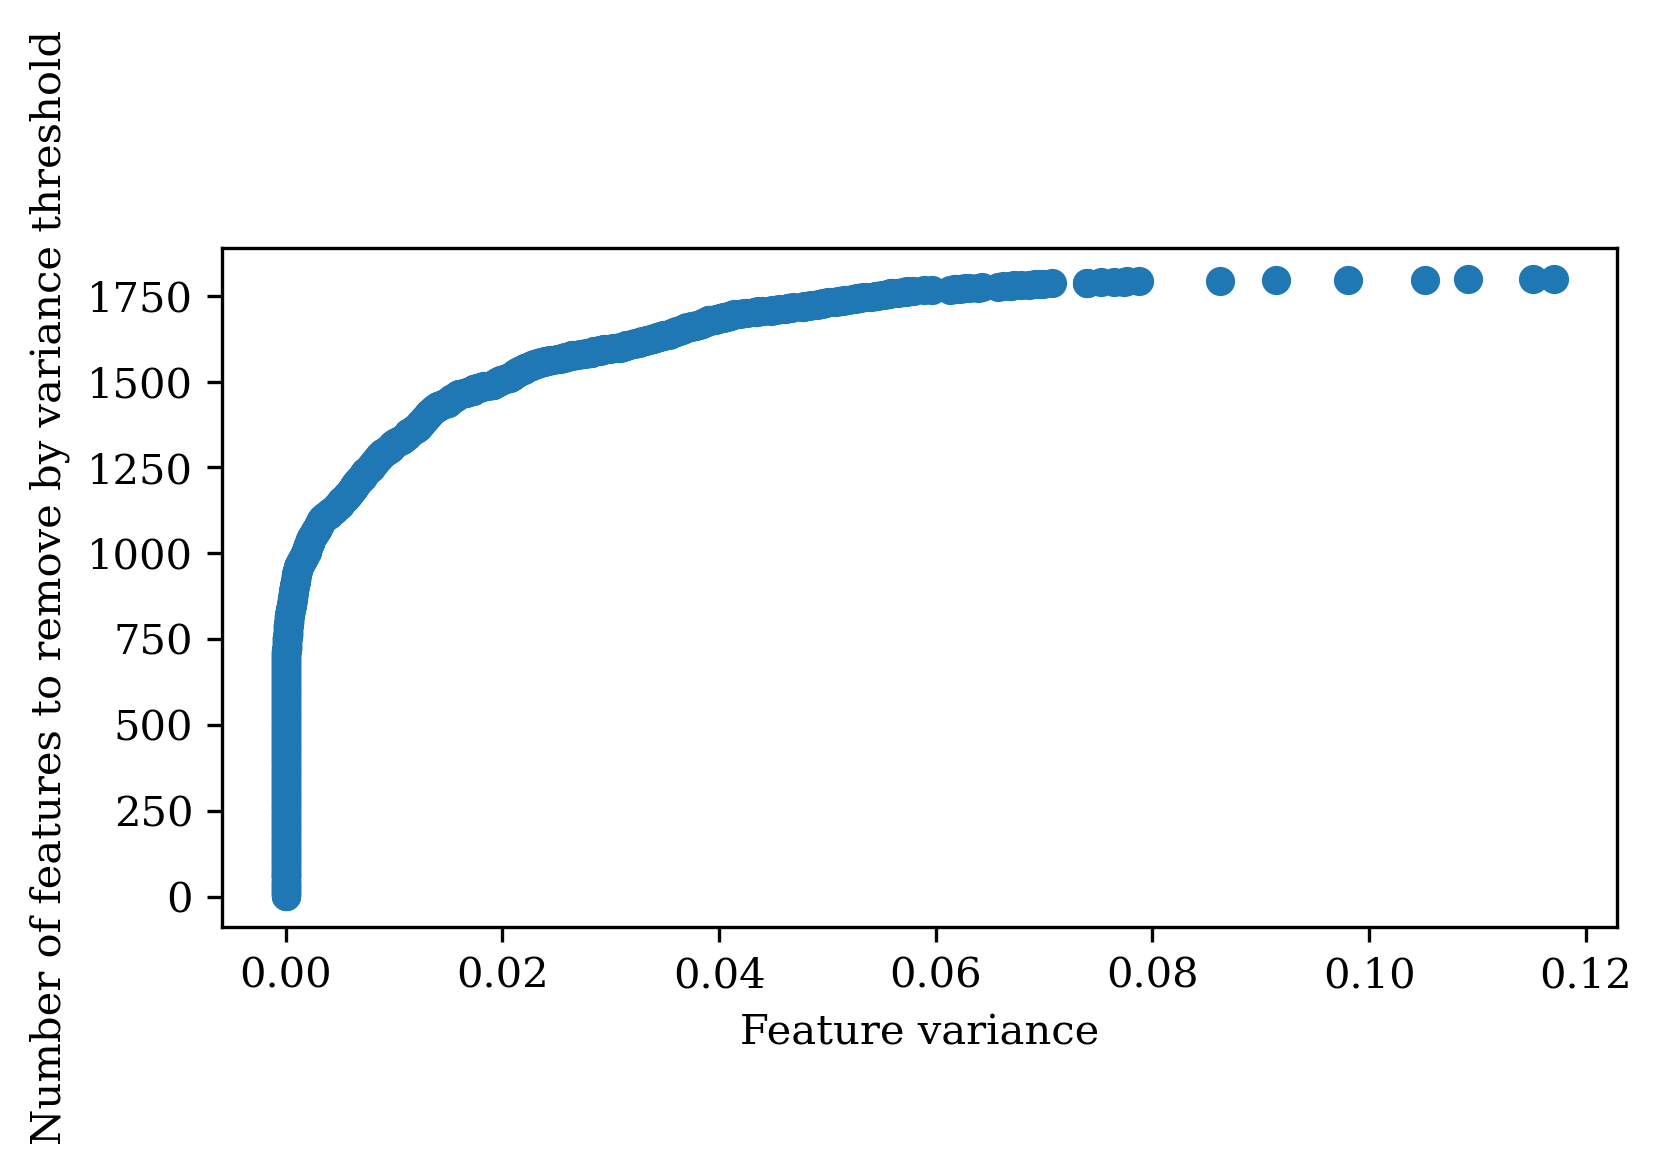

In [11]:
check_low_variance(X_train)

In [21]:
def low_variance_feature_selection(X_Train, df, df1, threshold):
    sel = VarianceThreshold(threshold)
    sel.fit_transform(X_Train)
    print("Features to be removed:",(~sel.get_support()).sum())
    
    #Capture features to retain from Training set
    feat_names = X_Train.columns[sel.get_support()]
    
    #Transform the full dataset and unique drug compound dataset
    X =  df.drop(['Drug','Class'],axis=1)
    X_df = sel.transform(X)
    X_df = pd.DataFrame(X_df,columns=feat_names)
    
    X1 = df1.drop(['Drug','Class'],axis=1)
    X_df_unique = sel.transform(X1)
    X_df_unique = pd.DataFrame(X_df_unique,columns=feat_names)
    
    # Features retained
    x_retained = [float(item) for item in feat_names]
    return X_df, X_df_unique, x_retained

In [28]:
df_variance, df_unique_variance,x_retained = low_variance_feature_selection(X_train, df, df_unique, 9.875538196576069e-06)

Features to be removed: 620


In [29]:
print(df_variance.shape)
print(df_unique_variance.shape)
print(len(x_retained))

(930, 1181)
(127, 1181)
1181


In [30]:
df_variance.to_csv(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset low variance.csv", index=False)
df_unique_variance.to_csv(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset low variance - Unique compounds.csv", index=False)

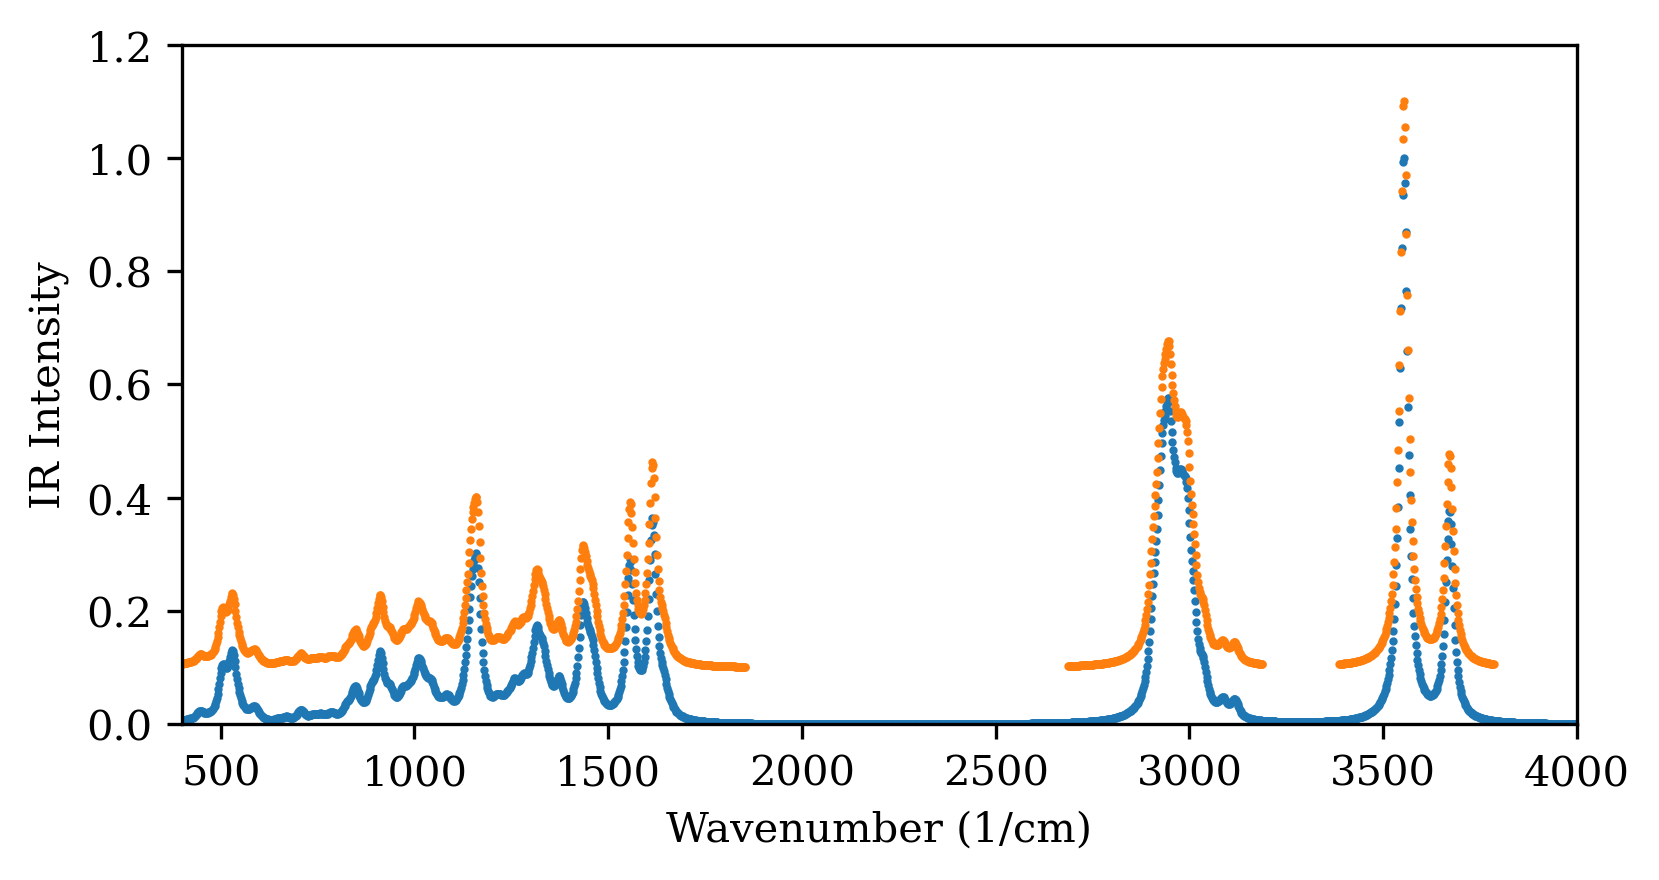

In [53]:
fig = plt.figure(figsize=(6,3), dpi=300)
plt.rc('font', family='serif', size = 10)
plt.xlabel('Wavenumber (1/cm)')
plt.ylabel('IR Intensity')
plt.xlim(400, 4000)
plt.ylim(0,1.2)
plt.scatter(full_feature,df.iloc[600,2:], s=1)
plt.scatter(x_retained,df_variance.iloc[600,:]+0.1, s=1)
plt.show()

## II. Feature selection

In [54]:
from skfeature.function.similarity_based import SPEC
from skfeature.function.sparse_learning_based import NDFS
from skfeature.function.sparse_learning_based import UDFS
from skfeature.function.similarity_based import lap_score
from skfeature.utility import construct_W
from skfeature.utility.sparse_learning import feature_ranking

#### Split the df_variance into 90% training and 10% test set for feature selection use kFold

* For each iteration, use training set to calculate feature importance score
* Repeat for 10-times 
* Plot scaled importance for each feature

In [365]:
X = df_variance
Y = df['Class'].astype('int64')

In [366]:
features = []
for col in df_variance.columns:
    features.append(col)

len(features)
features = [float(item) for item in features]

Check original X_train class distribution

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 28  46  77  17  75 112  70  46  10  59   9  67  78  72 117  47]
930


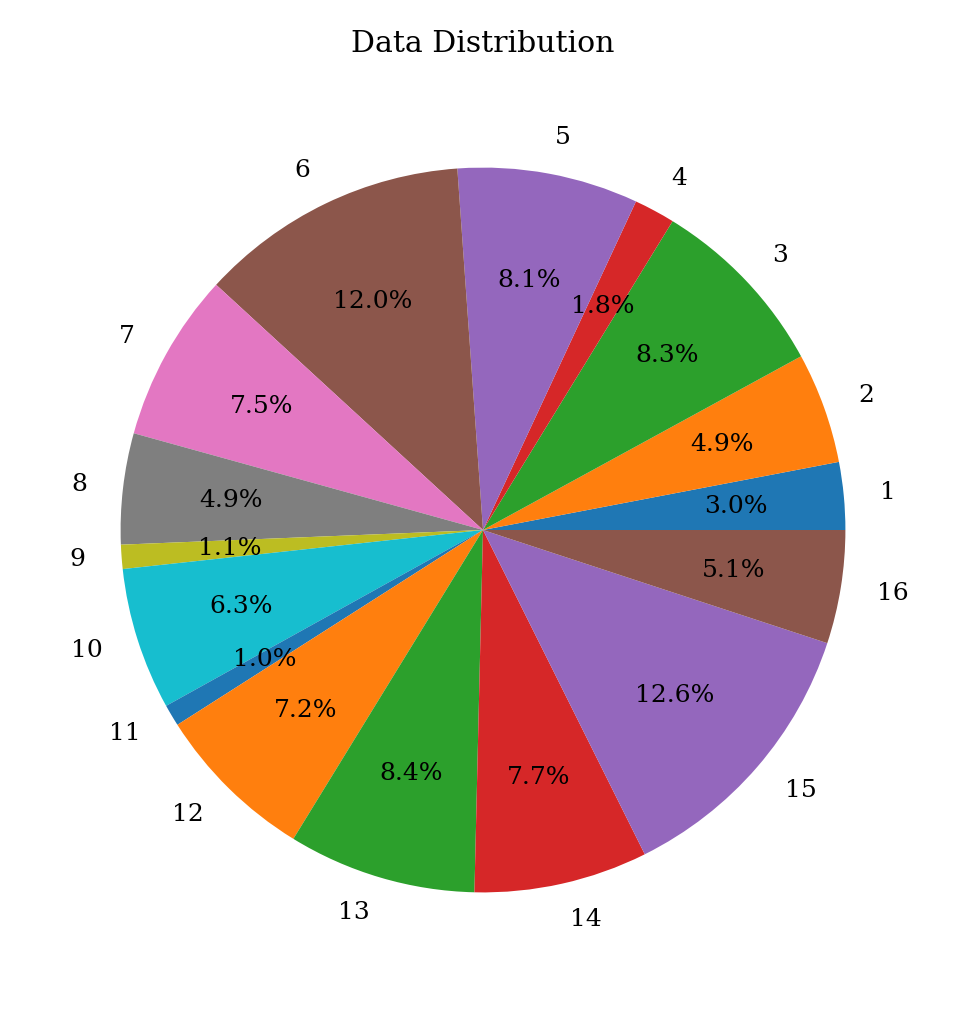

In [368]:
class_count = np.unique(Y,return_counts=True)
print(class_count[0])
print(class_count[1])
print(class_count[1].sum())
fig = plt.figure(figsize=(4,4), dpi=300)
plt.rc('font', family='serif', size = 6)
plt.pie(class_count[1],labels=class_count[0],autopct='%1.1f%%',pctdistance=0.7)
plt.title('Data Distribution')
plt.show()
fig.savefig(path+"Figure. DFT IR spectra dataset class distribution.png",  bbox_inches='tight')

* Class K = 6 and 15 have the most samples.
* SMOTE will oversample all classes to have the same number of samples as K = 15
* X_train after SMOTE with 1680 samples for 16 classes

In [212]:
kf=KFold(n_splits=10,shuffle=True,random_state=42)
sm = SMOTE( random_state=42)
X_train_resample_base=[]
Y_train_resample_base=[]
X_train_base=[]
Y_train_base=[]
X_test_base=[]
Y_test_base=[]
for train_index, test_index in kf.split(df_variance):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    Y_train, Y_test = Y[train_index], Y[test_index] 
    X_train_base.append(X_train)
    Y_train_base.append(Y_train)
    
    X_train_resample, Y_train_resample = sm.fit_resample(X_train,Y_train)
    
    X_train_resample_base.append(X_train_resample)
    X_test_base.append(X_test)
    Y_train_resample_base.append(Y_train_resample)
    Y_test_base.append(Y_test)
    print("Iteration:", )
    print("Resampled:", X_train_resample.shape, Y_train_resample.shape)
    print("Test:",X_test.shape, Y_test.shape)
    print("Train:", X_train.shape, Y_train.shape)

Iteration:
Resampled: (1680, 1181) (1680,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1728, 1181) (1728,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1744, 1181) (1744,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1728, 1181) (1728,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1664, 1181) (1664,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1712, 1181) (1712,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1696, 1181) (1696,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1632, 1181) (1632,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1712, 1181) (1712,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)
Iteration:
Resampled: (1632, 1181) (1632,)
Test: (93, 1181) (93,)
Train: (837, 1181) (837,)


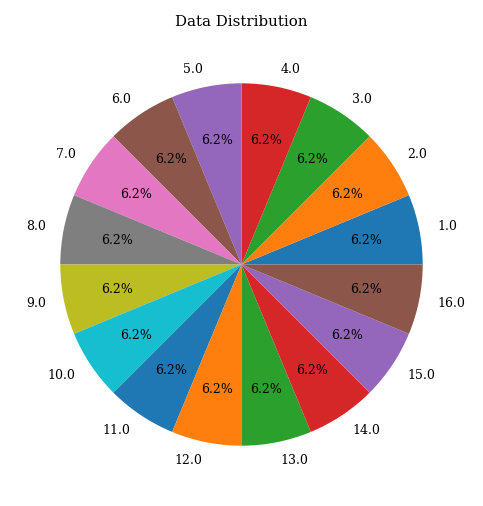

In [213]:
class_count = np.unique(Y_train_resample_base[0],return_counts=True)

fig = plt.figure(figsize=(4,4), dpi=150)
plt.rc('font', family='serif', size = 6)
plt.pie(class_count[1],labels=class_count[0],autopct='%1.1f%%',pctdistance=0.7)
plt.title('Data Distribution')
plt.show()

### Calculate feature importance score (scaled to 0 ~ 1) and plot comparison of four filter methods use 10-Kfold iteration

In [217]:
X_train_base[0].values

array([[8.91301935e-03, 8.55724550e-03, 8.18829006e-03, ...,
        7.52271403e-05, 7.42969801e-05, 7.33727514e-05],
       [8.73276423e-03, 8.33924154e-03, 7.89601390e-03, ...,
        7.22768488e-05, 7.13824081e-05, 7.04936844e-05],
       [5.67820057e-03, 6.16145812e-03, 6.72549675e-03, ...,
        6.90704032e-05, 6.82133319e-05, 6.73617999e-05],
       ...,
       [7.15693472e-02, 6.72038904e-02, 6.26503374e-02, ...,
        1.35143046e-03, 1.32191665e-03, 1.29313796e-03],
       [4.42342221e-02, 4.62831171e-02, 4.94380066e-02, ...,
        1.35694090e-03, 1.32708070e-03, 1.29796971e-03],
       [5.05639269e-02, 4.74747040e-02, 4.52250295e-02, ...,
        1.13166747e-03, 1.10715910e-03, 1.08325651e-03]])

In [284]:
def feature_rank(X_train,method):
    X = X_train.values
    if method.lower() == 'spec_rank':
        kwargs = {'style': 0}
        score = SPEC.spec(X, **kwargs)
    
    elif method.lower() == 'lap_rank':
        kwargs_W = {"metric": "euclidean", "neighbor_mode": "knn", "weight_mode": "heat_kernel", "k": 5, 't': 1}
        W = construct_W.construct_W(X, **kwargs_W)
        score = lap_score.lap_score(X, W=W)
        score = score**-1
    
    elif method.lower() == 'ndfs_rank':
        kwargs = {"metric": "euclidean", "neighborMode": "knn", "weightMode": "heatKernel", "k": 5, 't': 1}
        W = construct_W.construct_W(X, **kwargs)
        Weight = NDFS.ndfs(X, W=W, n_clusters=20)
        score = (Weight*Weight).sum(1)
    
    elif method.lower() == 'udfs_rank':
        Weight = UDFS.udfs(X, gamma=0.1, n_clusters=16)
        score = (Weight*Weight).sum(1)

    return score

In [312]:
def average_feature_rank(Data, method):
    df_tmp = pd.DataFrame()
    df_tmp['features'] = features
    for i in range(10):
        print('fold'+str(i+1))
        X_train = Data[i]
        score = feature_rank(X_train, method)
        score = min_max_scaler(score)
        #print(score[0:20])
        df_tmp['fold'+str(i+1)] = score
    print("10 iterations done")
    df_tmp['mean_score'] = df_tmp.iloc[:,1:11].mean(axis=1)
    return df_tmp

In [361]:
df_rank = average_feature_rank(X_train_base, "UDFS_rank")

df_rank.to_csv(path+"Feature importance score UDFS.csv",index=False)

fold1
fold2
fold3
fold4
fold5
fold6
fold7
fold8
fold9
fold10
10 iterations done


In [362]:
df_resample_rank = average_feature_rank(X_train_resample_base, "UDFS_rank")

df_resample_rank.to_csv(path+"Feature importance score UDFS - SMOTE.csv",index=False)

fold1
fold2
fold3
fold4
fold5
fold6
fold7
fold8
fold9
fold10
10 iterations done


In [360]:
df_rank[df_rank['mean_score']==max(df_rank.mean_score)]

,features,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9,fold10,mean_score
563,1526.0,0.000205,0.546667,0.613968,1.0,0.914852,1.0,1.0,0.827072,0.956749,1.0,0.785951


In [364]:
df_rank.shape

(1181, 12)

#### Scaled feature importance score plots

In [10]:
path = "/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/ML results/"
SMOTE = ' - SMOTE'

In [37]:
def score_plot(method,SMOTE):
    file1 = path+'Feature importance score '+method+'.csv'
    file2 = path+'Feature importance score '+method+SMOTE+'.csv'
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    x = df1.features
    y1 = df1.mean_score
    y2 = df2.mean_score
    
    fig = plt.figure(figsize=(6,2), dpi=600)
    plt.rc('font', family='serif', size = 8)
    plt.xlabel('Wavenumber (1/cm)')
    plt.ylabel('Feature importance score')
    plt.xlim(380, 3790)
    plt.xticks(np.arange(380, 3790,300))
    plt.ylim(0,1.05)
    plt.bar(x,y1, label = "Without SMOTE", alpha=0.7,width=1.5)
    plt.bar(x,y2, label = "SMOTE", alpha=0.5,width=1.5)
    plt.legend()
    legend = plt.legend(loc='upper left', shadow=True, fontsize=8)
    plt.show()
    fig.savefig(path+"Feature importance score "+method+" with vs. without SMOTE.png", bbox_inches='tight')

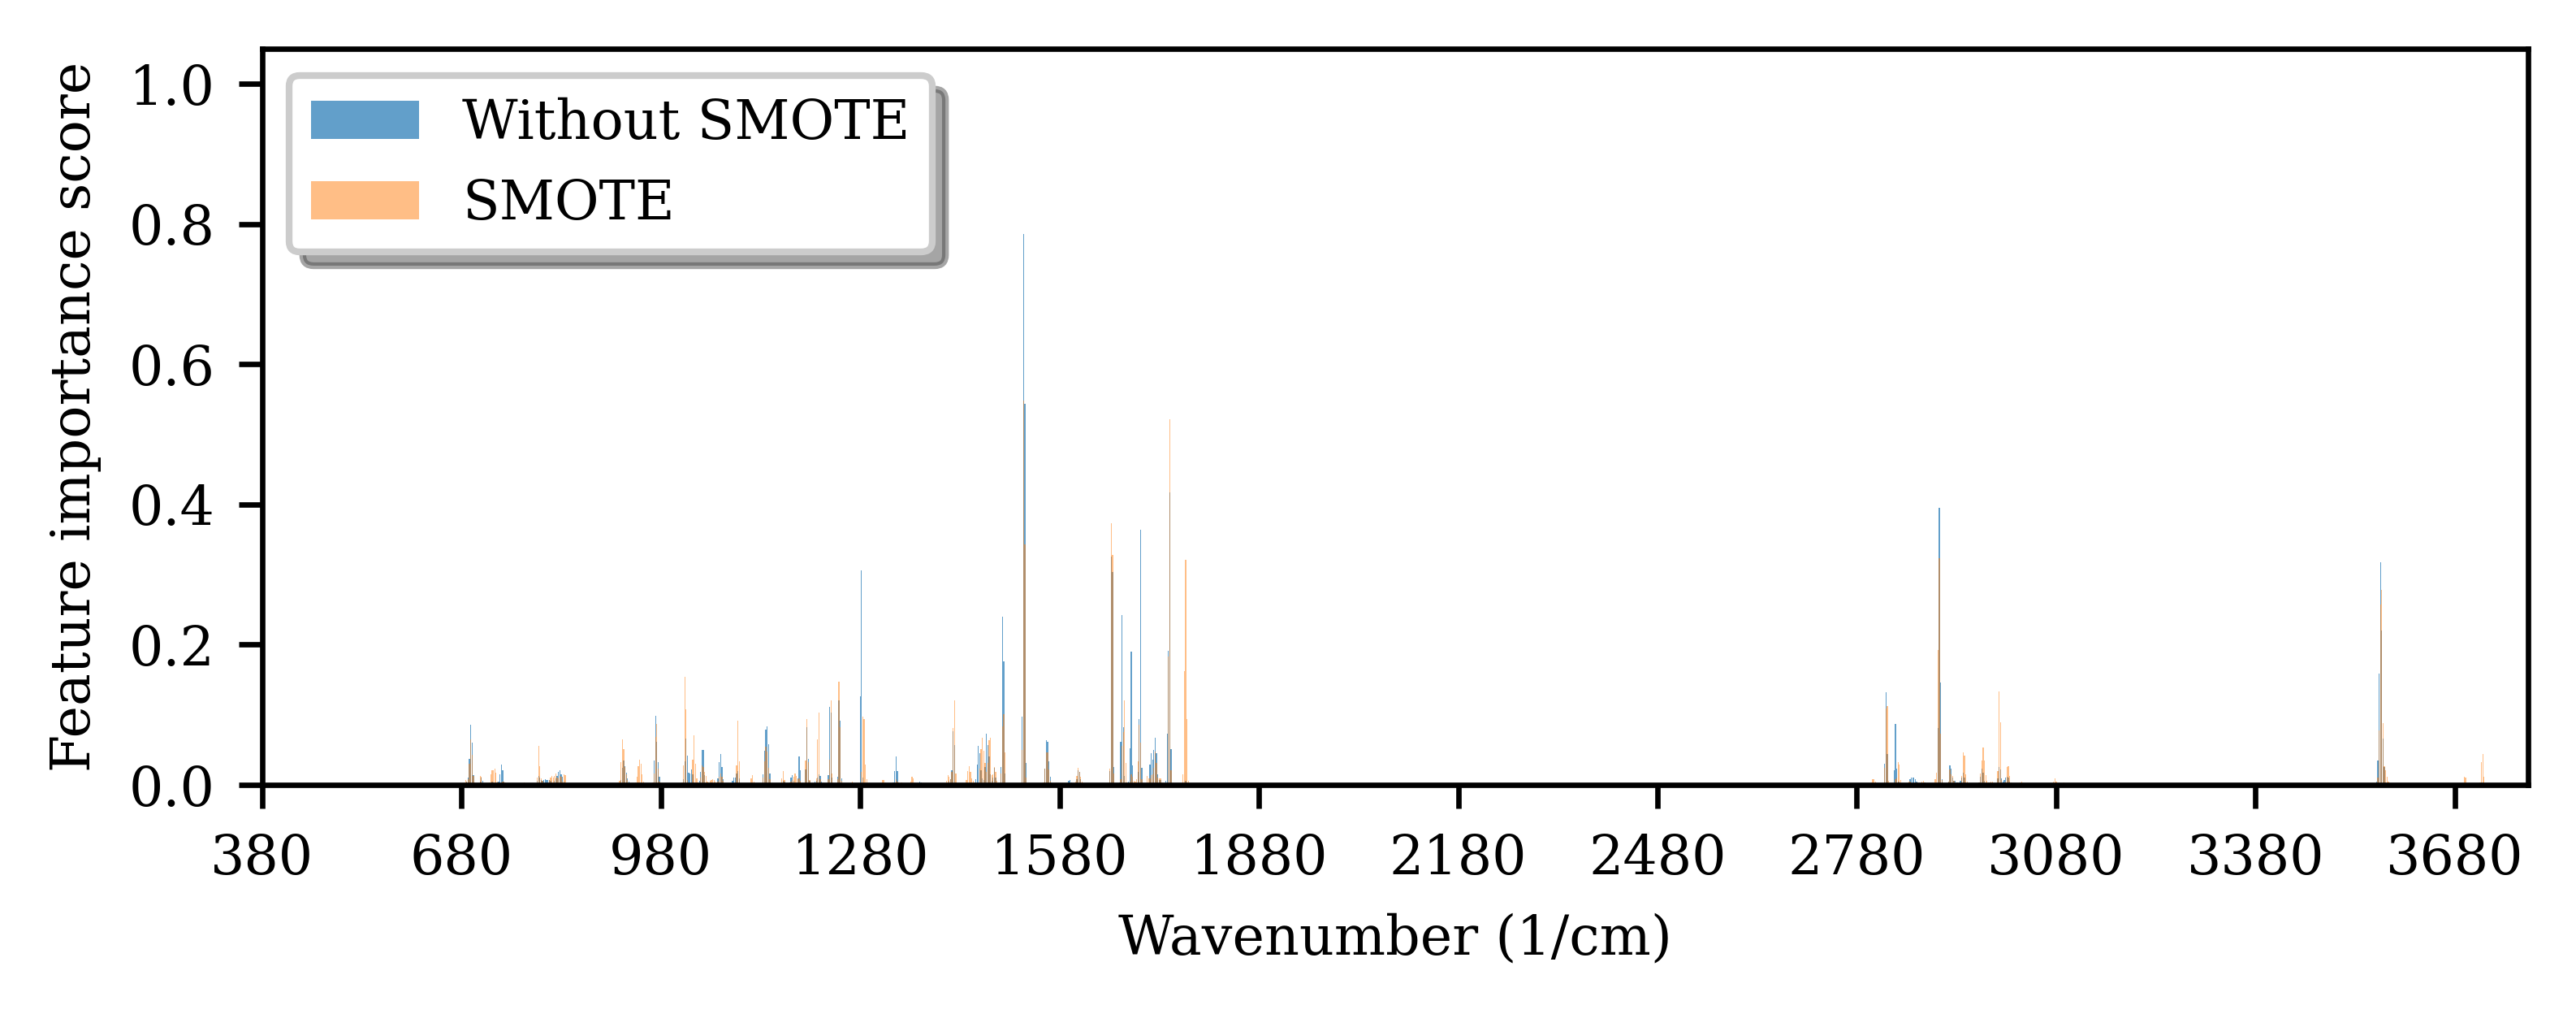

In [41]:
score_plot('NDFS',SMOTE)